<a href="https://colab.research.google.com/github/Laxmi-404/Deep-Learning/blob/main/DL5_DAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data normalization

Data augmentation

Residual connections

Batch normalization

Learning rate scheduling

Weight Decay

Gradient clipping

Adam optimizer





```
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio
```



In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Download the dataset:
root=r'C:\Users\Admin\OneDrive\Desktop\DEEP_LEARNING'
# dataset_url="https://files.fast.ai/data/cifar10.tgz"
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,root=root)

# Extract from archive
with tarfile.open(root+'/cifar10.tgz','r:gz') as tar:
  tar.extractall(path=root)

Using downloaded and verified file: C:\Users\Admin\OneDrive\Desktop\DEEP_LEARNING/cifar10.tgz


In [ ]:
# Look into data directory:
data_dir=root+'/cifar10'
print(os.listdir(data_dir))
classes=os.listdir(data_dir+'/train')
classes

['test', 'train']


['truck',
 'bird',
 'deer',
 'ship',
 'horse',
 'automobile',
 'cat',
 'frog',
 'airplane',
 'dog']

In [ ]:
os.listdir(data_dir+'/train/horse')

['1655.png',
 '0025.png',
 '1148.png',
 '1264.png',
 '0060.png',
 '4730.png',
 '0487.png',
 '1958.png',
 '0095.png',
 '0897.png',
 '1132.png',
 '2058.png',
 '3250.png',
 '4685.png',
 '3230.png',
 '2718.png',
 '2176.png',
 '1650.png',
 '0856.png',
 '1281.png',
 '2002.png',
 '3182.png',
 '4125.png',
 '4521.png',
 '3024.png',
 '0779.png',
 '0211.png',
 '4500.png',
 '4818.png',
 '0156.png',
 '4355.png',
 '3122.png',
 '0284.png',
 '0020.png',
 '0946.png',
 '2962.png',
 '2923.png',
 '1797.png',
 '0966.png',
 '3137.png',
 '0040.png',
 '3616.png',
 '0231.png',
 '4839.png',
 '0948.png',
 '1980.png',
 '2573.png',
 '1386.png',
 '3693.png',
 '2697.png',
 '1404.png',
 '1207.png',
 '0300.png',
 '0765.png',
 '2393.png',
 '3058.png',
 '2136.png',
 '3007.png',
 '4208.png',
 '1161.png',
 '1048.png',
 '3526.png',
 '2147.png',
 '0115.png',
 '1934.png',
 '0228.png',
 '0568.png',
 '3748.png',
 '1422.png',
 '2141.png',
 '1197.png',
 '3809.png',
 '4984.png',
 '2223.png',
 '2754.png',
 '0685.png',
 '0924.png',

In [ ]:
len(os.listdir(data_dir+'/train/horse'))

5000

In [ ]:
len(os.listdir(data_dir+'/test/horse'))

1000

Use test set for validation:

Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.

Channel-wise data normalization:

We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

Randomized data augmentations:

 We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

Data Augmentation do no use for validation set.

In [ ]:
#Data transform(normalization data augmentation)
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
# mean and std dev
train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])
# normalize needs to work with train and val dataset both bcoz model now knows only the scaled pixel values.

RandomCrop(32, padding=4, padding_mode='reflect'):
This transformation randomly crops a 32x32 area from the image, adding padding of 4 pixels on all sides before the crop. The padding is filled using a reflect mode, meaning the padded area will mirror the edge values of the image.

In [ ]:
train_ds=ImageFolder(data_dir+'/train',train_tfms)
valid_ds=ImageFolder(data_dir+'/test',valid_tfms)

In [ ]:
batch_size=400

In [ ]:
from torch.utils.data import DataLoader
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size*2,num_workers=2,pin_memory=True)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [ ]:
def show_batch(dl):
  for images,labels in dl:
    fig,ax=plt.subplots(figsize=(12,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
    break

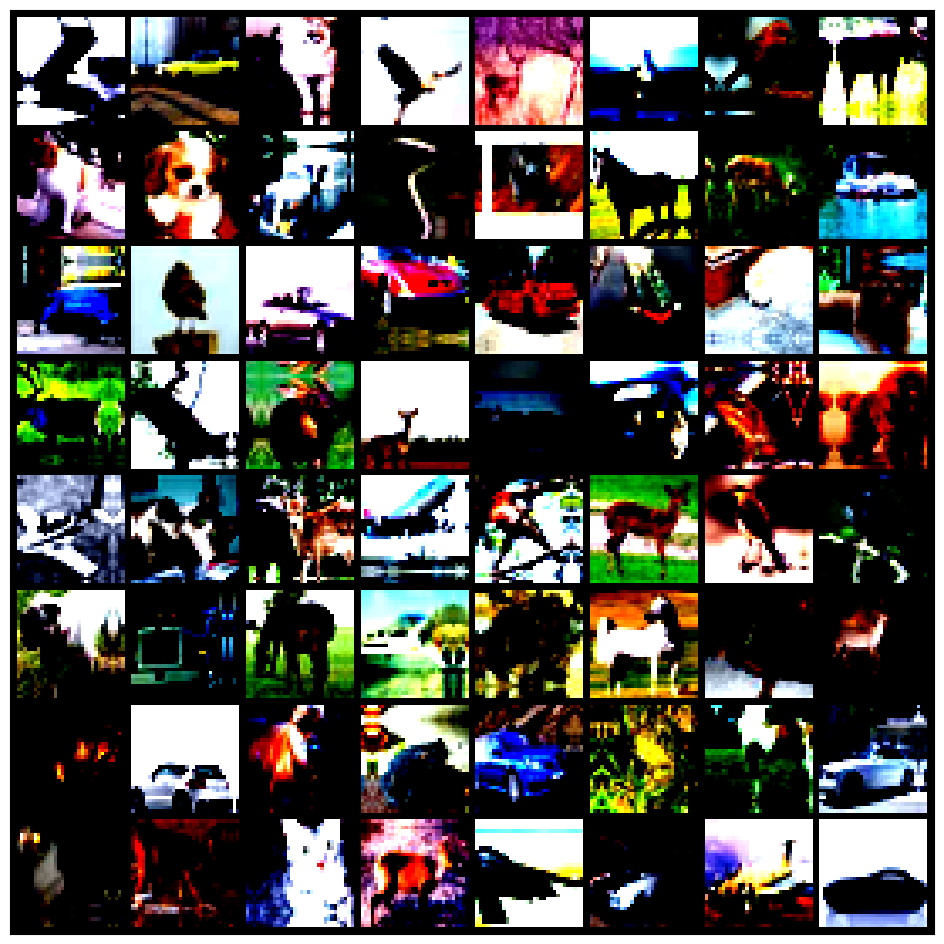

In [ ]:
show_batch(train_dl)

scaled_values,so colors are slightly shifted and sharper..

In [ ]:
# Pick GPU if available else CPU
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

# Move tensor to hosen device
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking= True)

# Wrap a dataloader to move data to device
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

# Yield a batch of data after moving to device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

# Number of batches
  def __len__(self):
    return len(self.dl)

Check if data is a list or tuple:

The isinstance(data, (list, tuple)) checks if data is either a list or a tuple. This is useful because sometimes, we might want to pass a list or tuple of tensors to the device. So, this condition allows the function to handle those cases.
Recursively move each item in the list/tuple to the device:
If data is a list or tuple, it iterates over each element (x) in the list/tuple and recursively calls to_device(x, device) to move each element to the specified device.
The list comprehension [to_device(x, device) for x in data] handles that.

Move a tensor to the device:
If data is a single tensor (not a list or tuple), the function uses data.to(device, non_blocking=True) to move the tensor to the specified device (e.g., GPU or CPU).

The non_blocking=True argument allows for asynchronous data transfer (useful if you're working with a GPU), meaning the operation can proceed without waiting for the data transfer to complete (useful for performance).

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)
# every epoch,diff trnsformation
# rotation,hue

A residual block is a key concept in deep learning, especially in architectures like ResNet (Residual Networks). It allows the network to learn residual mappings instead of learning the desired underlying mapping directly. This helps overcome the problem of vanishing gradients and makes training deeper networks easier and more efficient.

input+activation fn relu after applying convolution

Imagine you are processing an image with a 2D convolution. A ResNet block helps the network focus on what's different between the original input image and the processed features, rather than trying to recreate the image from scratch. By adding the original image back, it guides the network to learn the features it didn’t capture and to keep track of the important parts of the image.

Imagine you're a teacher trying to help a student solve a difficult math problem. The student keeps making mistakes because the problem is too long and complicated. Instead of having the student start over from scratch each time, you decide to help by reminding them of their previous answer, so they don’t forget what they did before. This way, the student can build on their previous knowledge and not lose progress.

In a ResNet block, instead of starting from scratch (layer after layer), we let the network remember what it has already learned and add that information to the next layer’s output. This makes learning easier and faster, especially when the network gets deeper.



In [ ]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu1=nn.ReLU()
    self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2=nn.ReLU()
  def forward(self,x):
    out=self.conv1(x)
    out=self.relu1(out)
    out=self.conv2(out)
    # return self.relu(out+x)
    return self.relu2(out)+x
# ReLU can be applied before or after adding the input

When you define a convolutional layer, you specify the number of filters (or kernels). These filters are learned during training, and their purpose is to detect different features from the image (such as edges, textures, or patterns).
Each filter in a convolutional layer has the same number of channels as the input image.

For example, if your input image has 3 channels (RGB), each filter will have 3 channels (one for each color).
The kernel size of a filter could be something like 3x3, 5x5, etc., meaning it’s looking at a 3x3 or 5x5 region of the input image at a time.

In [ ]:
simple_resnet=to_device(SimpleResidualBlock(),device)

for images,labels in train_dl:
  out=simple_resnet(images)
  print(out.shape)
  break

del simple_resnet,images,labels
torch.cuda.empty_cache()

# input---->output(difference)

torch.Size([400, 3, 32, 32])


We cannot change channels in residual layer as it will not let elementwise addition possible.

This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

output H(x) = convolutional layer(R(x))+ original input(x)

Batch Normalization(subtracts a mean and divide by standard deviation):normalize in same range the activations

Purpose: ReLU is an activation function used to introduce non-linearity in neural networks, which allows them to model complex relationships in the data. It is applied after a convolutional layer or dense layer.

The mathematical definition of ReLU:
f(x)=max(0,x)

If the output is negative, it is set to 0; otherwise, the output remains same.

In the context of convolutional neural networks (CNNs), Batch Normalization (BN) is applied to the activations of a layer, typically before applying the ReLU activation function.

relued values can be normalized in same way after finding mean and standard deviation
ChatGPT said:
ChatGPT
Yes, you can normalize the values after applying the ReLU activation, but the typical practice is to apply Batch Normalization before ReLU for the reasons we discussed earlier. However, if you choose to normalize the values after applying ReLU, you can indeed calculate the mean and standard deviation and normalize them, but it might not yield the same benefits as the conventional approach (Batch Normalization before ReLU).

What Happens When You Apply Normalization After ReLU?
If you apply ReLU first and then normalize, you would first have a mixture of zero values (because ReLU clips negative values to zero) and positive values. Then, after calculating the mean and standard deviation, you would normalize the values as follows:

Steps for Normalization After ReLU:
ReLU Activation:

Apply the ReLU activation function to the input. ReLU will turn all negative values to zero, so you will have a set of activations where some values are positive and others are zero.
Calculate Mean and Standard Deviation:

After applying ReLU, compute the mean and standard deviation of the resulting activations.
Normalization:

normalized_value= value−mean/std_dev

This will scale your activations to have a mean of zero and a standard deviation of one.
Apply This Normalized Value:

Use these normalized values as the inputs to the next layer.
​



Yes, **Batch Normalization**, **ReLU**, and similar techniques are applied to **the outputs of convolutional layers**, which are based on pixel intensities and their transformations. Here's how these techniques work with respect to pixel intensities and their activations:

### 1. **Convolutional Layers:**
   - The convolutional layers in a CNN process **raw pixel intensities** from the input image. These pixels are typically in the form of a 3D tensor (height, width, channels) representing the image.
   - The convolutional filter kernels slide over these pixel values and compute weighted sums (or dot products) of pixel values, which are then passed through a non-linear activation function like ReLU.

### 2. **ReLU Activation:**
   - After convolution, we apply **ReLU (Rectified Linear Unit)** to the output to introduce non-linearity. This means:
     \[
     \text{ReLU}(x) = \max(0, x)
     \]
     - **ReLU** sets negative values to zero and keeps positive values intact. This operation helps the network learn complex patterns and relationships from the input data (which in this case, are pixel intensities).
   - After **ReLU**, the activations are not bounded and can take any positive value.

### 3. **Normalization (e.g., Batch Normalization):**
   - After applying ReLU, the activations (which are the output of the convolutional layers and ReLU) are **normalized**. This is where techniques like **Batch Normalization** come in.
   
   - **Batch Normalization** normalizes the activations of each feature (channel) over the entire mini-batch. The normalization is done using the **mean and standard deviation** of the activations for each channel across all the training samples in the mini-batch.
   
   - **Normalization** ensures that the activations are centered around zero and have a standard deviation of one. This prevents the model from having highly skewed or extremely large activation values, which can hinder learning.
   - **The reason Batch Normalization is used after ReLU** is that it ensures the network doesn't have extreme values due to the non-linearity (ReLU), making the model more stable and improving training efficiency.

### Pixel Intensities and Their Transformation:
- Initially, **raw pixel intensities** are input into the CNN. These values can be between 0 and 255 (for RGB images), but it's common to **normalize** pixel values before feeding them into the network (e.g., dividing by 255 to bring them into the range [0, 1]).
- During the convolution process, these pixel intensities are transformed via filters, and the resulting activations are passed through non-linearities like **ReLU**.
- After **ReLU**, the resulting activations (which can be either zero or positive) are often normalized using techniques like **Batch Normalization** to stabilize training.

### Example Flow for Image Pixel Processing:
1. **Input Image**: The raw pixel intensities are taken from the image.
   - Example: A 32x32 RGB image would have pixel values like:
     \[
     \text{Pixel values:} \, [[0, 255, 128], [32, 45, 200], ...]
     \]

2. **Convolution**: A convolutional filter is applied, and the resulting values are transformed.
   - Example: After convolution with a 3x3 filter, the output might be something like:
     \[
     \text{Convolution output:} \, [[4.5, 3.2, 1.1], [2.0, 4.5, 0.2], ...]
     \]

3. **ReLU Activation**: The output of the convolution is passed through ReLU to remove negative values.
   - Example (ReLU output):
     \[
     \text{ReLU output:} \, [[4.5, 3.2, 1.1], [2.0, 4.5, 0.2], ...]
     \]
   - Notice that negative values become zero (if any existed).

4. **Normalization** (Batch Normalization): The activations are normalized using the mean and standard deviation across the batch. This is done to improve training stability and convergence.
   - Example (Batch Normalized output):
     \[
     \text{Normalized output:} \, [[-0.3, 0.1, 0.2], [0.5, -0.2, 0.1], ...]
     \]
   - The result is that the activations now have a mean of 0 and standard deviation of 1, making them more suitable for further learning.

### Why Apply These Techniques to Pixel Intensities?
- **ReLU** is used after convolution to introduce non-linearity, allowing the model to learn more complex patterns from the data. It helps prevent the model from simply learning linear relationships.
  
- **Batch Normalization** helps stabilize the training by ensuring that the activations don't explode or vanish, and it speeds up convergence by keeping the activations in a reasonable range.

### When Not to Normalize?
- You don't typically apply normalization to the **input pixel values** (before the convolution), as normalizing the raw image data would already achieve a similar effect.

Instead, normalization is done after ReLU activation for **convolutional layer outputs** to ensure that the model can learn more effectively.

---

### Summary:
- The process starts with **raw pixel intensities** being passed through the convolutional layers, which extract features.

- After convolution, **ReLU** is applied to introduce non-linearity and allow the model to learn more complex features.

- **Batch Normalization** is often applied after ReLU to normalize the activations and ensure stable training.
- This flow helps the model to learn better representations of the data while improving convergence and reducing training instability.

If you are working with an image classification task and want to preprocess your data efficiently, applying ReLU followed by Batch Normalization is a well-established approach.

--->We are normalizing the features to do not let some features disproportionately affecting the results.

In [ ]:
  def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

  class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
      images,labels=batch
      out=self(images)
      loss=F.cross_entropy(out,labels)
      return loss

    def validation_step(self,batch):
      images,labels=batch
      out=self(images)
      loss=F.cross_entropy(out,labels)
      acc=accuracy(out,labels)
      return {'val_loss':loss.detach(),'val_acc':acc}

    def validation_epoch_end(self,outputs):
      batch_losses=[x['val_loss'] for x in outputs]
      epoch_loss=torch.stack(batch_losses).mean()
      batch_accs=[x['val_acc'] for x in outputs]
      epoch_acc=torch.stack(batch_accs).mean()
      return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
      print("Epoch [{}],last_lr:{:.5f},train_loss:{:.4f},val_loss:{:.4f},val_acc{:.4f}".format(epoch,result['lrs'][-1],
                                                                                               result['train_loss'],
                                                                                               result['val_loss'],
                                                                                               result['val_acc']))

In [ ]:
def conv_block(in_channels,out_channels,pool=False):
  layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)
class ResNet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1=conv_block(in_channels,64)   #3*64*32*32
    self.conv2=conv_block(64,128,pool=True)  #128*16*16
    self.res1=nn.Sequential(conv_block(128,128),
                            conv_block(128,128))  #128*16*16:residual

    self.conv3=conv_block(128,256,pool=True)  #256*8*8
    self.conv4=conv_block(256,512,pool=True)  #512*4*4
    self.res2=nn.Sequential(conv_block(512,512),
                            conv_block(512,512))  #512*4*4

    self.classifier=nn.Sequential(nn.MaxPool2d(4),#512*1*1
                                 nn.Flatten(),   #512
                                 nn.Linear(512,num_classes)
                                 )#512 to 10 probab
                                #  10 preds
  def forward(self,xb):
    x1=self.conv1(xb)
    x2=self.conv2(x1)
    x1_res=self.res1(x2)
    x2= x2 + x1_res
    x3=self.conv3(x2)
    x4=self.conv4(x3)
    x2_res=self.res2(x4)
    x4= x4 + x2_res
    out=self.classifier(x4)
    return out

In [ ]:
model=to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# Check the indentation of functions in class

The **learning rate** in deep learning refers to the size of the steps the model takes when adjusting its weights during training to minimize the loss function. It determines how much the model's parameters are updated in response to the calculated gradient of the loss function.

### **High Learning Rate:**
- **Definition**: A high learning rate means the model makes **larger updates** to its weights after each step.
- **Impact**:
  - The model will **converge faster** initially, but it might "overshoot" the optimal point because the steps are too large.
  - High learning rates can cause the model to **oscillate** around the optimal point and fail to settle at the best solution.
  - It can lead to a **loss of stability** in training, and in the worst case, the model may diverge, meaning it never converges to a minimum.
- **When to use**: High learning rates might be useful at the start of training when you're trying to quickly explore the parameter space, but they usually need to be reduced as training progresses (using techniques like learning rate schedules).

### **Low Learning Rate:**
- **Definition**: A low learning rate means the model makes **smaller updates** to its weights after each step.
- **Impact**:
  - The model will **converge more slowly** and require more iterations, but it has a better chance of **fine-tuning** the weights and finding the optimal solution.
  - A low learning rate helps prevent overshooting, but it can get stuck in local minima (suboptimal solutions).
  - It tends to lead to **more stable training** and is less likely to cause divergence.
- **When to use**: Low learning rates are often preferred in the later stages of training, as they allow the model to gradually find a good minimum without overshooting.

### **Balancing the Learning Rate:**
- **Too High**: If the learning rate is too high, you risk overshooting the optimal solution, leading to poor performance or training instability.
- **Too Low**: If the learning rate is too low, training may take an excessive amount of time and might get stuck in suboptimal points (local minima) without reaching the best possible solution.

### **Finding the Right Learning Rate:**
- **Learning Rate Scheduling**: Often, people start with a higher learning rate and gradually reduce it as training progresses. Techniques like **learning rate annealing**, **cyclical learning rates**, or **adaptive optimizers** like Adam can adjust the learning rate dynamically.
- **Learning Rate Finder**: Some advanced techniques (e.g., "learning rate finder") can help you empirically find an optimal learning rate by experimenting with different values during training.


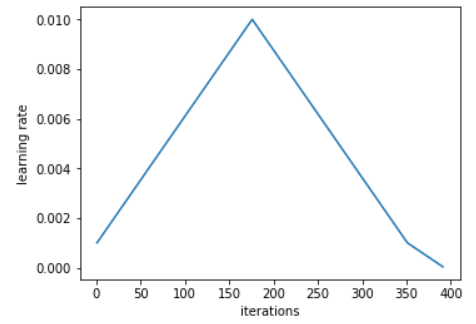

Here in starting more learning rate to quickly learn more but less steps to learn every aspect and finally settling to minimum.

First we normalize the inputs to not let any input feature to affect much.(inputs in any channels do not become large!)

none of the outputs become v.large(affect jada na kare)

weight of layer disproportionately affects the loss and gradient.

WEIGHT DECAY:
Loss = MSE(y_hat, y) + wd * sum(w^2)

minimize loss and weights low

backpropagation:gradients get too large(we can be thrown off completely from the path when gradients get too large!)

What gradient clipping do is that i will use gradient to decide how much step to take.But you do not want to use gradient for a large extent.If a gradient is larger than a particular value,i willjust threshold it...

In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In PyTorch, optimizer.param_groups refers to a list of dictionaries containing the parameters of the model that are being optimized, along with the corresponding hyperparameters such as the learning rate, momentum, and weight decay.

The param_groups is used when you have multiple sets of parameters in your model that you want to optimize with different settings. For example, you might want to apply different learning rates to different layers, or use different optimizers for specific parts of your model (like using a higher learning rate for the classifier layers and a lower one for the feature extractor layers).

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [ ]:
def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]

  # Setting up custom optimizer with weight decay:
  optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
# weight decay from-0.1 to .1

  # Setting up one-cyclelearning rate scheduler:
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
  # step per epoch tells how many batches trained per epoch.
# Total no of batches being trained:step_per_epoch*epochs

  for epoch in range(epochs):
    # Trainig phase(dropout,shufling,batch normalization,Randomization)
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      # gradients are calculated!

      # Gradient clipping
    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(),grad_clip)

      optimizer.step()#modify weights and bias
      optimizer.zero_grad()

      # Record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()#optimize lrs(normal gradient descent achieve)

    #Validation Phase
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['lrs']=lrs
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [ ]:
history=[evaluate(model,valid_dl)]
history

[{'val_loss': 2.3004536628723145, 'val_acc': 0.12240384519100189}]

SGD:What it does,it subtracts small value proprtional to gradient for each weight

Adam:adam optimizer uses momentum like using parameters from previous batch to achieve momentum.you dont bounce around too much.learn the direction to head.

Adaptive learning rate4s:eachlayer,we have factor multiplied with lr.

In [ ]:
epochs=16
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [ ]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0],last_lr:0.00040,train_loss:1.5146,val_loss:5.2499,val_acc0.1802
Epoch [1],last_lr:0.00040,train_loss:4.2288,val_loss:3.1285,val_acc0.2439
Epoch [2],last_lr:0.00040,train_loss:2.9862,val_loss:2.4548,val_acc0.2512
Epoch [3],last_lr:0.00040,train_loss:2.1238,val_loss:2.1366,val_acc0.2914
Epoch [4],last_lr:0.00040,train_loss:1.7615,val_loss:1.7086,val_acc0.4024
Epoch [5],last_lr:0.00040,train_loss:1.6586,val_loss:1.6767,val_acc0.4148
Epoch [6],last_lr:0.00040,train_loss:1.5978,val_loss:1.7041,val_acc0.4209
Epoch [7],last_lr:0.00040,train_loss:1.5667,val_loss:1.5031,val_acc0.4553
Epoch [8],last_lr:0.00040,train_loss:1.5419,val_loss:1.4642,val_acc0.4549
Epoch [9],last_lr:0.00041,train_loss:1.4824,val_loss:1.4234,val_acc0.4863
Epoch [10],last_lr:0.00041,train_loss:1.4268,val_loss:1.4009,val_acc0.4991
Epoch [11],last_lr:0.00041,train_loss:1.4013,val_loss:1.3205,val_acc0.5302
Epoch [12],last_lr:0.00041,train_loss:1.3683,val_loss:1.2669,val_acc0.5452
Epoch [13],last_lr:0.00041,train_lo

In [ ]:
def plot_accuracies(history):
  accuracies=[x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('No of epoch vs accuracy')

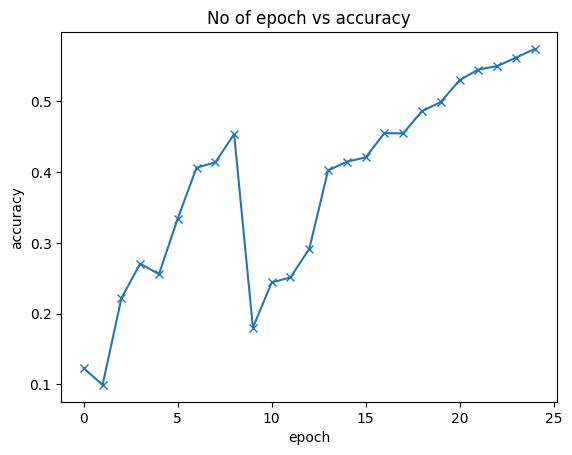

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses=[x.get('train_loss') for x in history]
  val_losses=[x['val_loss'] for x in history]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])
  plt.title('Loss vs no of epochs')

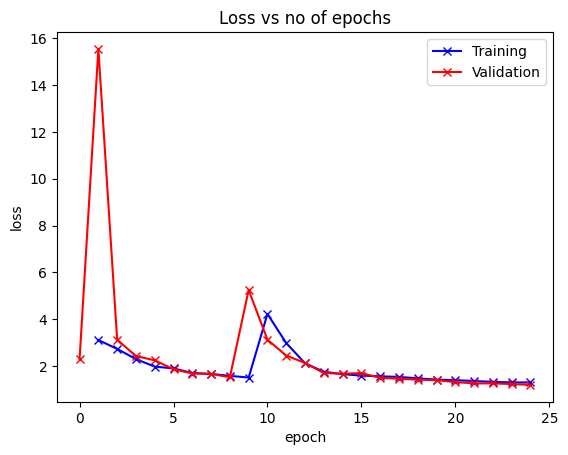

In [ ]:
plot_losses(history)

Reason for a drastic change?

In [ ]:
def plot_lrs(history):
  lrs=np.concatenate([x.get('lrs',[]) for x  in history])
  plt.plot(lrs)
  plt.xlabel('batch no')
  plt.ylabel('Learning Rate')
  plt.title('learning rate vs batch no')

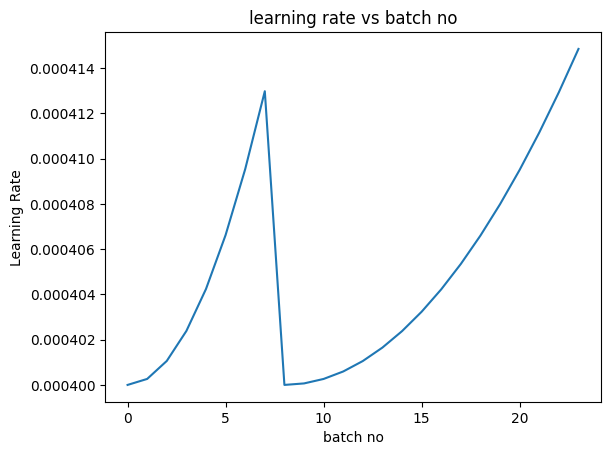

In [ ]:
plot_lrs(history)

Wrong graph kyu??

In [ ]:
torch.save(model.state_dict(),'cifar10-resnet9.pth')